In [1]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import cdist
import time
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd 
np.random.seed(5)
            
def updateMembershipValue3_2(v,val):
    distances = cdist(val, v,metric='euclidean')
    return distances


class FCM:
    def __init__(self, n_clusters=4, max_iter=50, m=2, error=1e-12):
        super().__init__()
        self.u, self.centers = None, None
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
        
    def fit(self, X):
        N = X.shape[0]
        C = self.n_clusters
        centers = self.centers #[]
        errorlist=[]
        
        u = np.random.dirichlet(np.ones(C), size=N)
        u = updateMembershipValue3_2(centers,X)

        iteration = 0
        start=time.time()
        while iteration < self.max_iter:
            
            u2 = u.copy()
            error=0

            centers = self.next_centers(X, u)
            u = self.next_u(X, centers)
            
#             ny=np.argmax(u,axis=1) 
#             v=centers
#             for q in range(v.shape[0]):
#                 error+=calcError(v[q],X[ny == q,:])
#             errorlist.append([error,time.time()- start])
    
            iteration += 1

#             # Stopping rule
#             if norm(u - u2) < self.error:
#                 break

        self.u = u
        self.centers = centers
        return centers,u,errorlist,time.time()- start

    def next_centers(self, X, u):
        um = u ** self.m
        return (X.T @ um / np.sum(um, axis=0)).transpose()

    def next_u(self, X, centers):
        return self._predict(X, centers)

    def _predict(self, X, centers):
        power = float(2 / (self.m - 1))
        temp = cdist(X, centers) ** power
        denominator_ = temp.reshape((X.shape[0], 1, -1)).repeat(temp.shape[-1], axis=1)
        denominator_ = temp[:, :, np.newaxis] / denominator_

        return 1 / denominator_.sum(2)

    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)

        u = self._predict(X, self.centers)
        return np.argmax(u, axis=-1)

In [2]:
def calcError(center,mem):
    dist=0
    for i in range(mem.shape[0]):
        dist+=np.linalg.norm(center - mem[i])
    return dist

In [3]:

# m=2 # fuzzyness
# e=0.1
# maxiter=10
# from sklearn.datasets.samples_generator import make_blobs


# cluster=2 # number of clusters
# datasetname='2class'

# cluster_std =[3,3]
# # cluster_std =[3,3,3,3]
# # cluster_std =[3,3,3,3,3,3]


# centers =[(-5, -5), (5, 5)] 
# # centers =[(0, 10), (0, 25), (0, 40), (0, 55)]
# # centers =[(-5, -5), (5, 5),(-5, 5), (5, -5),(15,5),(15,-5)]


# x, y = make_blobs(n_samples=1000, cluster_std=cluster_std, centers=centers, n_features=2, random_state=7,shuffle =True )

# for i in range ( cluster):
#     plt.scatter(x[y == i, 0], x[y == i, 1],  s=10, label="Cluster - "+str(i))

# plt.savefig(datasetname+'.jpg')
# plt.show() 


In [4]:

cluster=35
data=pd.read_csv('../../dataset/a2.txt', header=None, sep=',')  #
datasetname='a2'
x= np.asarray(data.iloc[:, :]) # np.asarray (data.iloc[:, :-1])
data.head() 

,0,1
0,53920,42968
1,52019,42206
2,52570,42476
3,54220,42081
4,54268,43420


In [5]:
def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Init n_clusters seeds according to k-means++
    Parameters
    ----------
    X : array or sparse matrix, shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy, the input data
        should be double precision (dtype=np.float64).
    n_clusters : integer
        The number of seeds to choose
    x_squared_norms : array, shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : int, RandomState instance
        The generator used to initialize the centers. Use an int to make the
        randomness deterministic.
        See :term:`Glossary <random_state>`.
    n_local_trials : integer, optional
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    return centers

In [6]:
# x_squared_norms = np.row_norms(x, squared=True)

x=np.asarray(x)

from sklearn.utils.extmath import row_norms
from sklearn.utils.extmath import row_norms, squared_norm, stable_cumsum
import scipy.sparse as sp
from sklearn.metrics.pairwise import euclidean_distances
 
c = _k_init(x,cluster, row_norms(x, squared=True), np.random.RandomState(7))
c

array([[44639, 26689],
       [25343, 54674],
       [52425, 41797],
       [ 8706, 29930],
       [47806, 59657],
       [35552, 48305],
       [ 9143, 49825],
       [26138, 26992],
       [62246, 51019],
       [59146, 28118],
       [35397, 38645],
       [15903, 39953],
       [19344, 62840],
       [43148, 53760],
       [ 8224, 40782],
       [16886, 55893],
       [32018, 59149],
       [21894, 45553],
       [ 4331, 23561],
       [56736, 59120],
       [44441, 44084],
       [17928, 25576],
       [42678, 35504],
       [10040, 60059],
       [ 5923, 55070],
       [50881, 47814],
       [30956, 44177],
       [49944, 24275],
       [55106, 35479],
       [35783, 56895],
       [39559, 27977],
       [62141, 43026],
       [ 2497, 53171],
       [ 4495, 44091],
       [35566, 43812]], dtype=int64)

In [7]:
fuzzy_cmeans2 = FCM(n_clusters=cluster,max_iter=50)
fuzzy_cmeans2.centers=c

In [8]:
v,u,errorlist,total_time=fuzzy_cmeans2.fit(x)

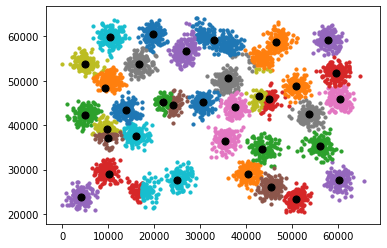

In [9]:

ny=np.argmax(u,axis=1)
for i in range ( cluster):
    plt.scatter(x[ny == i, 0], x[ny == i, 1],  s=10, label="Cluster - "+str(i))
plt.scatter(x=np.asarray(v)[:,0],y=np.asarray(v)[:,1], color='black',s=50)
plt.savefig(datasetname+'_'+str(total_time)+'_fcm.jpg')
plt.show()  

